## Introduction

The purpose of this notebook is running K-Means clustering to see if the algorithm can sucessfully cluster the news in to 'Real' & 'Fake' using just the words in the articles.

[Dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)

## Imports

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #  plotting and data visualization
import seaborn as sns # improve visuals
sns.set() # Set as default style

import string # python library
import re # regex library

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
#from gensim.models import Word2Vec # Word2vec
import gensim
from gensim.models.fasttext import FastText

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Metrics for evaluation
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

## Data Analysis & Cleanup

In [2]:
fake = pd.read_csv('../../datasets/Fake.csv.gz')
true = pd.read_csv('../../datasets/True.csv.gz')

In [3]:
fake.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [4]:
true.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


The first issue as seen above is that the True data contains:

1. A reuters disclaimer that the article is a tweet
> "The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own. Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump"


2. City Name and then publisher at the start
> WASHINGTON (Reuters)

so in the next block of code I remove this from the data

In [5]:
# The following is a crude way to remove the @realDonaldTrump tweet disclaimer and State/Publisher at start of text

cleansed_data = []
for data in true.text:
    if "@realDonaldTrump : - " in data:
        cleansed_data.append(data.split("@realDonaldTrump : - ")[1])
    elif "(Reuters) -" in data:
        cleansed_data.append(data.split("(Reuters) - ")[1])
    else:
        cleansed_data.append(data)

true["text"] = cleansed_data
true.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...",The White House said on Friday it was set to k...,politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...",President Donald Trump said on Thursday he bel...,politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,While the Fake News loves to talk about my so-...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,"Together, we are MAKING AMERICA GREAT AGAIN! b...",politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,Alabama Secretary of State John Merrill said h...,politicsNews,"December 28, 2017"


In [6]:
true.text[7]

'While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage & Russia hoax! [0746 EST] - Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packages, making Amazon richer and the Post Office dumber and poorer? Should be charging MUCH MORE! [0804 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) '

Some of the text still contains various characters/words such as:

1. Links
2. Timestamps
3. Brackets
4. Numbers

So we will be removing all such characters from the real and fake data using genlib preprocessing and a custom regex for the links in preperation for the Word2Vec

Before that however, the title and text will be merged in to one so that it can all be preprocessed together. I will also add a label for real and fake which will be used later to evaluate our clustering

In [7]:
# Merging title and text
fake['Sentences'] = fake['title'] + ' ' + fake['text']
true['Sentences'] = true['title'] + ' ' + true['text']

# Adding fake and true label
fake['Label'] = 0
true['Label'] = 1

# We can merge both together since we now have labels
final_data = pd.concat([fake, true])

# Randomize the rows so its all mixed up
final_data = final_data.sample(frac=1).reset_index(drop=True)

# Drop columns not needed
final_data = final_data.drop(['title', 'text', 'subject', 'date'], axis = 1)

final_data.head(10)

,Sentences,Label
0,"Trump backs Middle East peace, even if not tie...",1
1,WATCH: Tony Awards Gives Hateful Bigots The M...,0
2,Estonia arrests suspected Russian FSB agent Es...,1
3,Howard Dean: Democratic Party’s Tent Not Big E...,0
4,OBAMA’S OPEN BORDERS: ILLEGAL ALIEN DEPORTED 1...,0
5,Iran foreign minister tells lawmakers of plans...,1
6,DIRECTOR OF SOME OF MOST VIOLENT FILMS IN HOLL...,0
7,China's Xi: stable development of China-U.S. e...,1
8,BREAKING: ISIS SUPPORTERS THREATEN ARMED BIKER...,0
9,"Chad reshuffles finance, other key ministries ...",1


In [8]:
# Here we preprocess the sentences
def remove_URL(s):
    regex = re.compile(r'https?://\S+|www\.\S+|bit\.ly\S+')
    return regex.sub(r'',s)

# Preprocessing functions to remove lowercase, links, whitespace, tags, numbers, punctuation, strip words
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, remove_URL, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

# Here we store the processed sentences and their label
processed_data = []
processed_labels = []

for index, row in final_data.iterrows():
    words_broken_up = preprocess_string(row['Sentences'], CUSTOM_FILTERS)
    # This eliminates any fields that may be blank after preprocessing
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row['Label'])

## Word Model (FastText)

In [9]:
# Word2Vec model trained on processed data
#model = Word2Vec(processed_data, min_count=3)
text_model = FastText(vector_size=256, window=7, min_count=3, workers=os.cpu_count(), seed=42)
text_model.build_vocab(processed_data)

In [10]:
text_model.wv.most_similar("country")

[('country”', 0.7329877614974976),
 ('country’', 0.7301741242408752),
 ('“country', 0.7251217365264893),
 ('country’s', 0.6774489283561707),
 ('countryman', 0.6602391600608826),
 ('countryside', 0.6377427577972412),
 ('countrywide', 0.6088157296180725),
 ('countrymen', 0.6011219024658203),
 ('backcountry', 0.5782605409622192),
 ('count', 0.5341266393661499)]

## Sentence Vectors

In [11]:
def div_norm(x):
   norm_value = np.linalg.norm(x)
   if norm_value > 0:
       return x * ( 1.0 / norm_value)
   else:
       return x


def word_vector_to_sentence_vector(sentence:list, model):
    vectors = []
    # for all the tokens in the setence
    for token in sentence:
        if token in model:
            vectors.append(model[token])
    # add the EOS token
    if '\n' in model:
        vectors.append(model['\n'])
    # normalize all the vectors
    vectors = [div_norm(x) for x in vectors]
    return np.mean(vectors, axis=0)

In [12]:
X = []
for data_x in processed_data:
    X.append(word_vector_to_sentence_vector(data_x, text_model.wv))

In [13]:
X_np = np.array(X)
X_np.shape

(44889, 256)

## Clustering

In [26]:
# Training for 2 clusters (Fake and Real)
kmeans = cluster.KMeans(n_init='auto', n_clusters=2, verbose=1)

# Fit predict will return labels
clustered = kmeans.fit_predict(X_np)

Initialization complete
Iteration 0, inertia 1064.634521484375.
Iteration 1, inertia 738.4130249023438.
Iteration 2, inertia 735.2589111328125.
Iteration 3, inertia 733.7896728515625.
Iteration 4, inertia 733.1503295898438.
Iteration 5, inertia 732.7019653320312.
Iteration 6, inertia 732.2395629882812.
Iteration 7, inertia 731.802001953125.
Iteration 8, inertia 731.5610961914062.
Iteration 9, inertia 731.4296264648438.
Iteration 10, inertia 731.3833618164062.
Iteration 11, inertia 731.3593139648438.
Iteration 12, inertia 731.34912109375.
Iteration 13, inertia 731.3463134765625.
Iteration 14, inertia 731.3457641601562.
Iteration 15, inertia 731.34521484375.
Iteration 16, inertia 731.3451538085938.
Iteration 17, inertia 731.34521484375.
Converged at iteration 17: strict convergence.


In [24]:
testing_df = {'Sentence': processed_data, 'Labels': processed_labels, 'Prediction': clustered}
testing_df = pd.DataFrame(data=testing_df)

testing_df.head(10)

,Sentence,Labels,Prediction
0,"[trump, backs, middle, east, peace, tied, stat...",1,7
1,"[watch, tony, awards, gives, hateful, bigots, ...",0,1
2,"[estonia, arrests, suspected, russian, fsb, ag...",1,0
3,"[howard, dean, democratic, party’s, tent, big,...",0,6
4,"[obama’s, open, borders, illegal, alien, depor...",0,3
5,"[iran, foreign, minister, tells, lawmakers, pl...",1,3
6,"[director, violent, films, hollywood, joins, c...",0,1
7,"[china, stable, development, china, economic, ...",1,5
8,"[breaking, isis, supporters, threaten, armed, ...",0,1
9,"[chad, reshuffles, finance, key, ministries, d...",1,3


The results above show that its correctly clustered them in some cases where 0 is fake news and 1 is real news

In [25]:
correct = 0
incorrect = 0
for index, row in testing_df.iterrows():
    if row['Labels'] == row['Prediction']:
        correct += 1
    else:
        incorrect += 1
        
print("Correctly clustered news: " + str((correct*100)/(correct+incorrect)) + "%")

Correctly clustered news: 7.554189222303905%


## Visualization

In [17]:
# PCA of sentence vectors
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_np)

PCA_df = pd.DataFrame(pca_result)
PCA_df['cluster'] = clustered
PCA_df.columns = ['x1','x2','cluster']

In [18]:
# T-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X_np)

TSNE_df = pd.DataFrame(tsne_result)
TSNE_df['cluster'] = clustered
TSNE_df.columns = ['x1','x2','cluster']

Text(0.5, 1.0, 'Visualized on PCA')

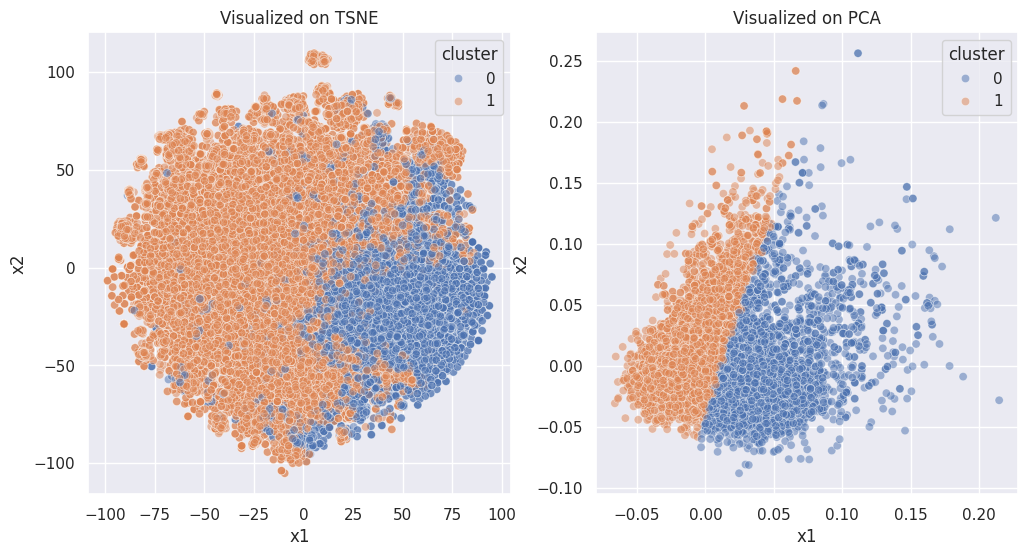

In [19]:
# Plots
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=PCA_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1])
sns.scatterplot(data=TSNE_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('Visualized on TSNE')
ax[1].set_title('Visualized on PCA')

## Custom News Tests

In [20]:
# Testing with fake news generated from https://www.thefakenewsgenerator.com/
onion_data = "Flint Residents Learn To Harness Superpowers, But Trump Gets Away Again They developed superpowers after years of drinking from a lead-poisoned water supply. But just having incredible abilities doesn't make them superheroes. Not yet. Donald Trump faced off against the superpowered civilians but he got away before they could catch him"

# Preprocess article
onion_data = preprocess_string(onion_data, CUSTOM_FILTERS)

# Get sentence vector
onion_data = word_vector_to_sentence_vector(onion_data, text_model.wv)

# Get prediction
kmeans.predict(np.array([onion_data]))

array([0], dtype=int32)

In [21]:
# News from BBC
bbc_data = "Nasa Mars 2020 Mission's MiMi Aung on women in space Next year, Nasa will send a mission to Mars. The woman in charge of making the helicopter that will be sent there – which is set to become the first aircraft to fly on another planet – is MiMi Aung. At 16, MiMi travelled alone from Myanmar to the US for access to education. She is now one of the lead engineers at Nasa. We find out what it's like being a woman in space exploration, and why her mum is her biggest inspiration."

# Preprocess article
bbc_data = preprocess_string(bbc_data, CUSTOM_FILTERS)

# Get sentence vector
bbc_data = word_vector_to_sentence_vector(bbc_data, text_model.wv)

# Get prediction
kmeans.predict(np.array([bbc_data]))

array([1], dtype=int32)